# Self-Driving Car Nanodegree

## Project: Finding Lane Lines on the Road

In [80]:
# Import packages

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [81]:
import os
test_imgs = os.listdir("test_images/")

### Read an Image

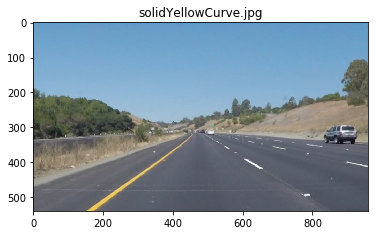

The image is the type <class 'numpy.ndarray'> and the image shape (540, 960, 3)


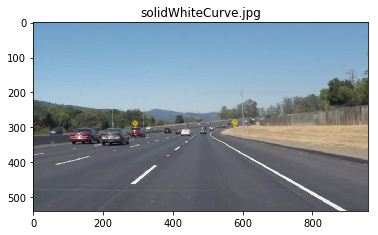

The image is the type <class 'numpy.ndarray'> and the image shape (540, 960, 3)


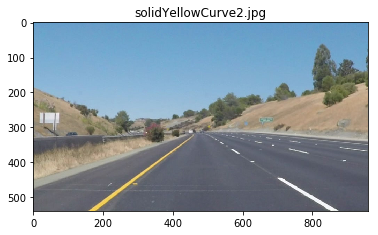

The image is the type <class 'numpy.ndarray'> and the image shape (540, 960, 3)


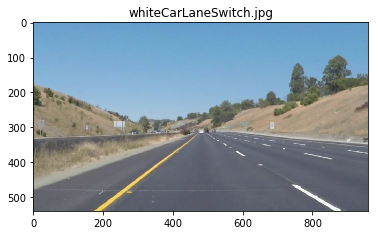

The image is the type <class 'numpy.ndarray'> and the image shape (540, 960, 3)


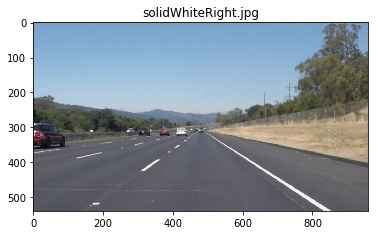

The image is the type <class 'numpy.ndarray'> and the image shape (540, 960, 3)


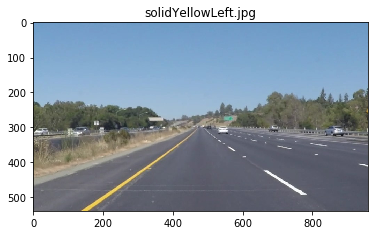

The image is the type <class 'numpy.ndarray'> and the image shape (540, 960, 3)


In [82]:
read_imgset = []

for img in test_imgs:
    image = mpimg.imread("test_images/{}".format(img))
    read_imgset.append(image)
    plt.figure()
    plt.title(img)
    plt.imshow(image)
    plt.show()
    print("The image is the type {} and the image shape {}".format(type(image), image.shape))

### Grayscale Image

In [83]:
def grayscale(img):
    """
    Applies the GrayScale transform.
    This will return an image with only one color channel
    NOTE: To view the image in grayscale you should call the following
    plt.imshow(image, cmap="gray")
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [84]:
gray_imgset = []

for img in read_imgset:
    gray = grayscale(img)
    gray_imgset.append(gray)
    # plt.figure()
    # plt.imshow(gray, cmap="gray")

### Gaussian Blur

In [85]:
def gaussian_blur(img, kernel_size):
    """ Applies a Gaussian Noise kernal"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [86]:
gaussian_imgset = []

for img in gray_imgset:
    gaussian = gaussian_blur(img = img, kernel_size=5)
    gaussian_imgset.append(gaussian)
   # plt.figure()
   # plt.imshow(gaussian, cmap="gray")

### Canny Edges

In [87]:
def canny(img, low_threshold, high_threshold):
    """ Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

In [88]:
canny_imgset = []

for img in gaussian_imgset:
    canny_img = canny(img, 50, 150)
    canny_imgset.append(canny_img)
   # plt.figure()
   # plt.imshow(canny_img, cmap="gray")

### Region of Interest

In [89]:
def region_of_interest(img, vertices):
    '''
    Applies an image mask.
    
    Only keep the region of the image defined by the polygon
    formed from 'vertices'. The rest of the image is set to black
    '''
    
    # defining a blank mask to start with
    mask = np.zeros_like(img)
    
    # Defining a 3 channel or 1 channel color to fill the mask with
    # depending on the input image
    if len(img.shape) > 2:
        channel_count = image_shape[2]
        ignore_mask_color = (255, ) * channel_count
    else:
        ignore_mask_color=255
    
    # Filling the Pixels inside the polygon defined by 'vertices' with
    # the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # Returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [90]:
region_imgset = []

for img in canny_imgset:
    
    imshape = img.shape
    vertices = np.array([[(0,imshape[0]),(450, 315), (490, 315), (imshape[1],imshape[0])]], dtype=np.int32)

    masked_image = region_of_interest(img, vertices)

    region_imgset.append(masked_image)
  #  plt.figure()
  #  plt.imshow(masked_image)

### Draw Lines

In [255]:
def draw_lines(img, lines, color=[255, 0, 255], thickness=3):    
    """ 
    Function to draw a line
    Takes an array of hough lines and separates them by positive/
    negatives slopes.
    The y-axis is inverted in matplotlib, so the calculated positve 
    slopes will be right lanes and negative slopes will be left lanes
    Equation being used: y = mx + c; m = gradient, c = intercept
    """
    
    right_m = []
    right_c = []
    left_m = []
    left_c = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = ((y2-y1)/(x2-x1))
            c = y2 - m * x2
            if m < 0:
                right_m.append(m)
                right_c.append(c)
            elif m > 0:
                left_m.append(m)
                left_c.append(c)
                
    # Averaging values of slopes and y_intercepts of our left and right lines 
    # (median is used as a good measure of centre because the distribution of values are skewed)
    right_slope = np.median(right_m)
    right_intercept = np.median(right_c)
    left_slope = np.median(left_m)
    left_intercept = np.median(left_c)    
    
    # A helper function to return two points for each of our left 
    # and right lines by finding intersection points 
    # (between our lines and horizontal lower and upper limit lines)
    def get_points(m, c):
        y1 = img.shape[0]
        y2 = 315
        x1 = (y1 - c) / m
        x2 = (y2 - c) / m
        line = np.array([[x1, y1, x2, y2]], dtype = 'int32')
        return line
    
    # we finally get our two coordinate points for each of the left and right lines 
    lines = []
    left_line = get_points(left_slope, left_intercept)
    lines.append(left_line)
    right_line = get_points(right_slope, right_intercept)
    lines.append(right_line)
    
    # Drawing left and right lines
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

### Hough Transform

In [256]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """ Returns an image with hough lines drawn"""
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

In [257]:
hough_imgset = []

for img in region_imgset:
    hough_img = hough_lines(img, rho=1, theta=np.pi/180, threshold=15, min_line_len=40, max_line_gap=20)
    hough_imgset.append(hough_img)
    # plt.figure()
    # plt.imshow(hough_img)

In [258]:
def weighted_img(img, initial_img, alpha=0.8, beta=1, gamma=0):
    """An image with lines drawn"""
    return cv2.addWeighted(initial_img, alpha, img, beta, gamma)

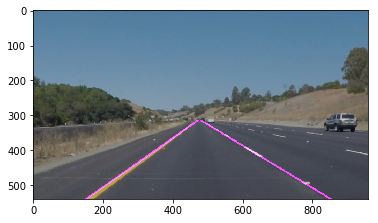

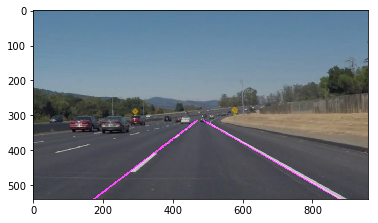

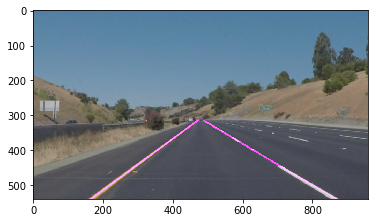

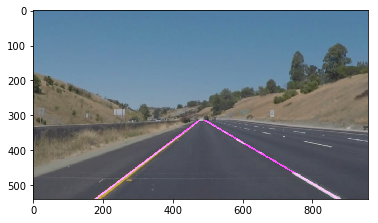

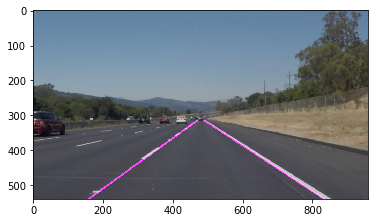

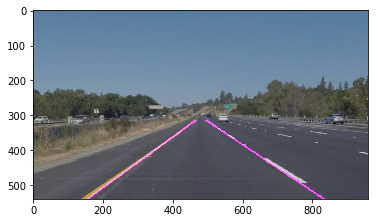

In [259]:
for i in range(0,6):
    final_img = weighted_img(hough_imgset[i], read_imgset[i])
    plt.figure()
    plt.imshow(final_img)